# Next Character Prediction
_Student 902011, Moleri Andrea, a.moleri@campus.unimib.it_

The task is next character prediction in a text. Starting from the provided skeleton of the code:

- properly divide the sequences into training, validation and test. Eventually use an external text for the test to assess the generalization ability
- evaluate the trained model in terms of prediction accuracy
- tune the chunk length to obtain the best performance
- modify the network architecture to obtain the best performance

In aggiunta:

Comunque vuole sia il notebook che la stampa in PDF del notebook 

### Inspecting the Data

Opening file...
Text Length: 558240

****** First 1000 characters ******

inferno



inferno: canto i


nel mezzo del cammin di nostra vita
  mi ritrovai per una selva oscura
  che' la diritta via era smarrita.

ahi quanto a dir qual era e` cosa dura
  esta selva selvaggia e aspra e forte
  che nel pensier rinova la paura!

tant'e` amara che poco e` piu` morte;
  ma per trattar del ben ch'i' vi trovai,
  diro` de l'altre cose ch'i' v'ho scorte.

io non so ben ridir com'i' v'intrai,
  tant'era pien di sonno a quel punto
  che la verace via abbandonai.

ma poi ch'i' fui al pie` d'un colle giunto,
  la` dove terminava quella valle
  che m'avea di paura il cor compunto,

guardai in alto, e vidi le sue spalle
  vestite gia` de' raggi del pianeta
  che mena dritto altrui per ogne calle.

allor fu la paura un poco queta
  che nel lago del cor m'era durata
  la notte ch'i' passai con tanta pieta.

e come quei che con lena affannata
  uscito fuor del pelago a la riva
  si volge a l'acqua perigl

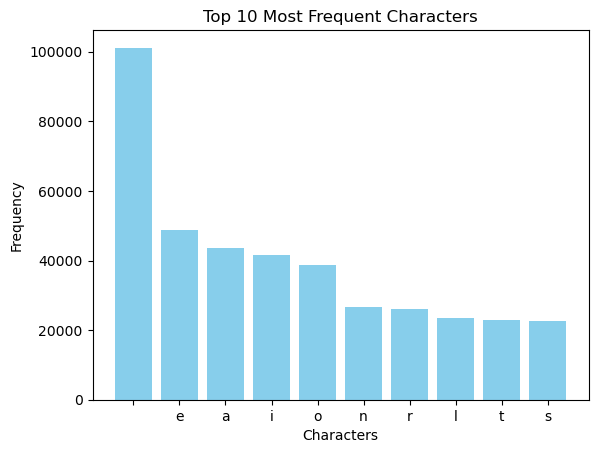

In [16]:
import io
import numpy as np
import random
import requests

import tensorflow as tf
from tensorflow import keras
from keras.callbacks import LambdaCallback
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

print('Opening file...')

# Define the URL of the "Divina Commedia" text file 
path = 'https://raw.githubusercontent.com/andreamoleri/AML-Assignments/refs/heads/main/Assignment%204/divina_commedia.txt'

# Fetch the content of the text file from the specified URL
response = requests.get(path)
response.raise_for_status()  # Ensure that the request was successful
text = response.text.lower()  # Convert the text to lowercase for uniformity

# Display the length of the text and the first 1000 characters for inspection
print('Text Length:', len(text))
print('\n****** First 1000 characters ******\n')
print(text[:1000])

# Create a sorted list of unique characters present in the text
chars = sorted(list(set(text)))
print('total chars: ', len(chars))

# Create mappings from characters to indices and vice versa
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

# Display the character-to-index and index-to-character mappings
print(char_indices)
print(indices_char)

# Define the maximum length of each sequence and the step size for creating sequences
maxlen = 30 
step = 3

# Initialize lists to store the sequences and their corresponding next characters
sentences = []
next_chars = []

# Generate overlapping sequences of length `maxlen` and their corresponding next characters
for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i: i + maxlen])
    next_chars.append(text[i + maxlen])

# Display the number of sequences created and examples of sequences and next characters
print('number of sequences: ', len(sentences))
print(sentences[11])
print(next_chars[11])

# Calculate the frequency of each character in the text
from collections import Counter
char_counts = Counter(text)

# Sort the characters by their frequency in descending order
sorted_counts = sorted(char_counts.items(), key=lambda x: x[1], reverse=True)

# Display the top 10 most frequent characters and their frequencies
print('\nTop 10 most frequent characters:')
for char, count in sorted_counts[:10]:
    print(f"'{char}': {count} occurrences")

# Plot a bar chart of the top 10 most frequent characters
import matplotlib.pyplot as plt
char_labels, char_freqs = zip(*sorted_counts[:10])
plt.bar(char_labels, char_freqs, color='skyblue')
plt.title('Top 10 Most Frequent Characters')
plt.xlabel('Characters')
plt.ylabel('Frequency')
plt.show()

In [11]:
## Preparing the data

# Defining sequence length for training
maxlen = 40  # Length of each sequence (chunk)
step = 3     # Step size for moving the window

# Creating sequences and corresponding next characters
sentences = []
next_chars = []

for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i: i + maxlen])
    next_chars.append(text[i + maxlen])

print(f'Number of sequences generated: {len(sentences)}')

# Creating a mapping of unique characters to indices
chars = sorted(set(text))
char_indices = {char: idx for idx, char in enumerate(chars)}
indices_char = {idx: char for char, idx in char_indices.items()}

# Generating one-hot encoded training data
x = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool_)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool_)

for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

print(f'Shape of input data (x): {x.shape}')
print(f'Shape of output data (y): {y.shape}')

# Splitting the data into training, validation, and test sets
from sklearn.model_selection import train_test_split

# Splitting sentences and labels into training (80%), validation (10%), and test (10%)
x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.2, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

print(f'Training data shape: x_train {x_train.shape}, y_train {y_train.shape}')
print(f'Validation data shape: x_val {x_val.shape}, y_val {y_val.shape}')
print(f'Test data shape: x_test {x_test.shape}, y_test {y_test.shape}')

# Optional: Using an external text file for testing (generalization assessment)
external_path = base_dir + 'external_test.txt'  # Replace with actual file name/path
try:
    with io.open(external_path, encoding='utf-8') as f:
        external_text = f.read().lower()
    print(f'External test file loaded successfully: {len(external_text)} characters')
    
    # Preparing the external test set
    external_sentences = []
    external_next_chars = []
    for i in range(0, len(external_text) - maxlen, step):
        external_sentences.append(external_text[i: i + maxlen])
        external_next_chars.append(external_text[i + maxlen])

    x_ext = np.zeros((len(external_sentences), maxlen, len(chars)), dtype=np.bool_)
    y_ext = np.zeros((len(external_sentences), len(chars)), dtype=np.bool_)

    for i, sentence in enumerate(external_sentences):
        for t, char in enumerate(sentence):
            if char in char_indices:
                x_ext[i, t, char_indices[char]] = 1
        if external_next_chars[i] in char_indices:
            y_ext[i, char_indices[external_next_chars[i]]] = 1

    print(f'External test data shape: x_ext {x_ext.shape}, y_ext {y_ext.shape}')

except FileNotFoundError:
    print('External test file not found. Skipping external test data preparation.')

Number of sequences generated: 186067
Shape of input data (x): (186067, 40, 40)
Shape of output data (y): (186067, 40)
Training data shape: x_train (148853, 40, 40), y_train (148853, 40)
Validation data shape: x_val (18607, 40, 40), y_val (18607, 40)
Test data shape: x_test (18607, 40, 40), y_test (18607, 40)


NameError: name 'base_dir' is not defined

In [10]:
model = Sequential()
model.add(LSTM(128, input_shape=(maxlen, len(chars))))
model.add(Dense(len(chars), activation='softmax'))

optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 128)                 │          86,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 40)                  │           5,160 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 91,688 (358.16 KB)

 Trainable params: 91,688 (358.16 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
import sys
def testAfterEpoch(epoch, _):
  print()
  print()
  print('******* Epoch: %d ********' % (epoch+1))
  start_index = random.randint(0, len(text)-maxlen-1)

  generated = ''
  sentence = text[start_index :  start_index + maxlen]
  generated = generated + sentence

  print('***** starting sentence *****')
  print(sentence)
  print('*****************************')
  sys.stdout.write(generated)

  for i in range(400):
    x_pred = np.zeros((1, maxlen, len(chars)))
    for t, char in enumerate(sentence):
      x_pred[0, t, char_indices[char]] = 1

    preds = model.predict(x_pred, verbose=0)[0]
    next_index = np.argmax(preds)
    next_char = indices_char[next_index]

    sentence = sentence[1:] + next_char

    sys.stdout.write(next_char)
    sys.stdout.flush()
  print()



In [12]:
print_callback = LambdaCallback(on_epoch_end=testAfterEpoch)

In [13]:
model.fit(x, y,
          batch_size = 2048,
          epochs = 20,
          callbacks = [print_callback])

Epoch 1/20
90/91 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 2.9393

******* Epoch: 1 ********
***** starting sentence *****
ltimo e` tutto d'angelici ludi
*****************************
ltimo e` tutto d'angelici ludi si sia che sia che sia che sia che sia che sia che sia che sia che sia che sia che sia che sia che sia che sia che sia che sia che sia che sia che sia che sia che sia che sia che sia che sia che sia che sia che sia che sia che sia che sia che sia che sia che sia che sia che sia che sia che sia che sia che sia che sia che sia che sia che sia che sia che sia che sia che sia che sia che sia che sia 
91/91 ━━━━━━━━━━━━━━━━━━━━ 27s 277ms/step - loss: 2.9326
Epoch 2/20
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 2.1241

******* Epoch: 2 ********
***** starting sentence *****
isa di scorpion la punta armav
*****************************
isa di scorpion la punta armave se la suo che suo che suo che suo che suo che suo che suo che suo che suo che suo che suo che suo che suo che su

Exception ignored in: <function _xla_gc_callback at 0x7bd496a4b520>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 96, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


 discender di quella spena
  che son discender di quella spena
  che son discender di quell

KeyboardInterrupt: 